In [1]:
import csv
import time
import string
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def fit_in_pi(t):
    theta = t
    while np.max(theta) > math.pi:
        theta[theta > math.pi] -= 2 * math.pi
    while np.min(theta) < -math.pi:
        theta[theta < -math.pi] += 2 * math.pi
    return theta

## OptiTrack data

In [4]:
runs = ['many_slow_static', 'many_slow_static_2', 'many_slow_static_3',
        'many_slow_dynamic', 'many_slow_dynamic_2', 'many_slow_dynamic_3',
        'many_fast_static', 'many_fast_static_2', 'many_fast_static_3',
        'many_fast_dynamic', 'many_fast_dynamic_2', 'many_fast_dynamic_3',
        'few_slow_static', 'few_slow_static_2', 'few_slow_static_3',
        'few_slow_dynamic', 'few_slow_dynamic_2', 'few_slow_dynamic_3',
        'few_fast_static', 'few_fast_static_2', 'few_fast_static_3',
        'few_fast_dynamic', 'few_fast_dynamic_2', 'few_fast_dynamic_3']

In [5]:
## OptiTrack data
# Read csv
opti_csv = {}
for run in runs:
    opti_csv[run] = pd.read_csv('OptiTrack/'+run+'.csv', skiprows=107, names=['frame', 'time', 'rx', 'ry', 'rz', 'rw', 'x', 'y', 'z'])
    
# Clean wired scenario
opti_csv['few_fast_dynamic_2'] = opti_csv['few_fast_dynamic_2'][opti_csv['few_fast_dynamic_2']['time']>15]

## Process OptiTrack data

In [6]:
opti_keys = ['timestamp', 'opti_x', 'opti_y', 'opti_theta']

In [7]:
# Fit data into nanosecond and meter
opti_data = {}
for run in runs:
    opti_dat = pd.DataFrame(columns=opti_keys)
    opti_dat['timestamp'] = np.round(opti_csv[run]['time'] * (10 ** 9))
    opti_dat['opti_x'] = opti_csv[run]['z'] / 1000
    opti_dat['opti_y'] = opti_csv[run]['x'] / 1000
    opti_dat['opti_theta'] = fit_in_pi(2 * np.arctan2(opti_csv[run]['ry'],opti_csv[run]['rw']) + math.pi / 2)
    
    opti_dis = np.sqrt(np.square(opti_dat['opti_x'])+np.square(opti_dat['opti_y']))
    opti_filter = opti_dat[opti_dis.abs() >= (0.001 + opti_dis.iloc[0])]
    opti_dat['timestamp'] -= np.min(opti_filter['timestamp'])
    opti_data[run] = opti_dat
    opti_data[run] = opti_data[run].sort_values(by=['timestamp'])
opti_data['many_slow_static']['opti_theta'] = fit_in_pi(opti_data['many_slow_static']['opti_theta'] - math.pi / 2)

## ROS data

In [8]:
# Read csv
pi_csv = {}
jetson_csv = {}
for run in runs:
    pi_csv[run] = pd.read_csv('Pi/' + run + '.csv')
    jetson_csv[run] = pd.read_csv('Jetson/' + run + '.csv')

# Clean wired scenario
jetson_csv['few_fast_dynamic_2'] = jetson_csv['few_fast_dynamic_2'][jetson_csv['few_fast_dynamic_2']['rostimestamp'] > 1568284443375520000]

## Process ROS data

In [9]:
pi_keys = ['timestamp', 'vel_linear', 'vel_angular',
              'odom_x', 'odom_y', 'odom_theta',
              'realsense_x', 'realsense_y', 'realsense_theta']

jetson_keys = ['timestamp',
              'orb_x', 'orb_y', 'orb_theta',
              'zed_x', 'zed_y', 'zed_theta']

In [10]:
pi_data = {}
jetson_data = {}

# Keep only the data we want into dictionary
for run in runs:   
    pi_dat = pd.DataFrame(columns=pi_keys)
    pi_dat['timestamp']= pi_csv[run]['rostimestamp']
    pi_dat['vel_linear'] = pi_csv[run]['/cmd_vel:linear_x']
    pi_dat['vel_angular'] = pi_csv[run]['/cmd_vel:angular_z']
    pi_dat['odom_x'] = pi_csv[run]['/odom:pose_pose_position_x']
    pi_dat['odom_y'] = pi_csv[run]['/odom:pose_pose_position_y']
    pi_dat['odom_theta'] = fit_in_pi(2 * np.arctan2(pi_csv[run]['/odom:orientation_z'],pi_csv[run]['/odom:orientation_w']))
    pi_dat['realsense_x'] = pi_csv[run]['/camera/odom/sample:pose_pose_position_x']
    pi_dat['realsense_y'] = pi_csv[run]['/camera/odom/sample:pose_pose_position_y']
    pi_dat['realsense_theta'] = fit_in_pi(2 * np.arctan2(pi_csv[run]['/camera/odom/sample:orientation_z'],pi_csv[run]['/camera/odom/sample:orientation_w']))
    pi_filter = pi_dat[pi_dat['vel_linear'] >= 0]
    pi_dat['timestamp'] -= np.min(pi_filter['timestamp'])
    pi_data[run] = pi_dat[pi_dat['timestamp'] > 0]
    pi_data[run] = pi_data[run].sort_values(by=['timestamp'])
    
    jetson_dat = pd.DataFrame(columns=jetson_keys)
    jetson_dat['timestamp'] = jetson_csv[run]['rostimestamp']
    jetson_dat['orb_x'] = jetson_csv[run]['/orb_slam2_zedm_left/pose:pose_position_x']
    jetson_dat['orb_y'] = jetson_csv[run]['/orb_slam2_zedm_left/pose:pose_position_y']
    jetson_dat['orb_theta'] = fit_in_pi(2 * np.arctan2(jetson_csv[run]['/orb_slam2_zedm_left/pose:orientation_z'],jetson_csv[run]['/orb_slam2_zedm_left/pose:orientation_w']))
    jetson_dat['zed_x'] = jetson_csv[run]['/pose:pose_position_x']
    jetson_dat['zed_y'] = jetson_csv[run]['/pose:pose_position_y']
    jetson_dat['zed_theta'] = fit_in_pi(2 * np.arctan2(jetson_csv[run]['/pose:orientation_z'],jetson_csv[run]['/pose:orientation_w']))
    jetson_filter = jetson_dat[jetson_dat['zed_x'].abs() >= 0.001]
    jetson_dat['timestamp'] -= np.min(jetson_filter['timestamp'])
    jetson_data[run] = jetson_dat
    jetson_data[run] = jetson_data[run].sort_values(by=['timestamp'])

## Merge data

In [12]:
'''
def computeMergeCost(x, ref_x, t):
    copy_x = x.copy()
    copy_x['timestamp'] -= t
    merge = pd.merge(copy_x, ref_x, on='timestamp', how='outer')
    merge = merge.sort_values(by=['timestamp'])
    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='ffill')
    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='bfill')
    merge = merge.dropna(how='any')
    J = (np.square(merge[copy_x.keys()[-1]]-merge[ref_x.keys()[-1]])).sum()
    return J

def computeOffset(x, ref_x):
    t = np.min(x['timestamp'])
    min_t = t
    min_J = computeMergeCost(x, ref_x, t)
    for t in x['timestamp']:
        J = computeMergeCost(x, ref_x, t)
        if J < min_J:
            min_J = J
            min_t = t
        print(str(t) + ': ' + str(min_t) + ': ' + str(J) + '          ', end='\r')
    print(str(np.min(x['timestamp'])) + '&' + str(np.max(x['timestamp'])) + ': ' + str(min_t) + ': ' + str(min_J) + '          ')
    return min_t
'''

"\ndef computeMergeCost(x, ref_x, t):\n    copy_x = x.copy()\n    copy_x['timestamp'] -= t\n    merge = pd.merge(copy_x, ref_x, on='timestamp', how='outer')\n    merge = merge.sort_values(by=['timestamp'])\n    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='ffill')\n    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='bfill')\n    merge = merge.dropna(how='any')\n    J = (np.square(merge[copy_x.keys()[-1]]-merge[ref_x.keys()[-1]])).sum()\n    return J\n\ndef computeOffset(x, ref_x):\n    t = np.min(x['timestamp'])\n    min_t = t\n    min_J = computeMergeCost(x, ref_x, t)\n    for t in x['timestamp']:\n        J = computeMergeCost(x, ref_x, t)\n        if J < min_J:\n            min_J = J\n            min_t = t\n        print(str(t) + ': ' + str(min_t) + ': ' + str(J) + '          ', end='\r')\n    print(str(np.min(x['timestamp'])) + '&' + str(np.max(x['timestamp'])) + ': ' + str(min_t) + ': ' + str(min_J) + '          ')\n    return min_t\n"

In [13]:
'''
def computeMergeCost(x, ref_x, t):
    copy_x = x.copy()
    copy_x['timestamp'] -= t
    merge = pd.merge(copy_x, ref_x, on='timestamp', how='outer')
    merge = merge.sort_values(by=['timestamp'])
    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='ffill')
    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='bfill')
    merge = merge.dropna(how='any')
    J = (np.square(fit_in_pi(merge[copy_x.keys()[-1]]-merge[ref_x.keys()[-1]]))).sum()
    return J

def computeThetaOffset(x, ref_x):
    t = np.min(x['timestamp'])
    min_t = t
    min_J = computeMergeCost(x, ref_x, t)
    for t in x['timestamp']:
        J = computeMergeCost(x, ref_x, t)
        if J < min_J:
            min_J = J
            min_t = t
        print(str(t) + ': ' + str(min_t) + ': ' + str(J) + '          ', end='\r')
    print(str(np.min(x['timestamp'])) + '&' + str(np.max(x['timestamp'])) + ': ' + str(min_t) + ': ' + str(min_J) + '          ')
    return min_t
'''

"\ndef computeMergeCost(x, ref_x, t):\n    copy_x = x.copy()\n    copy_x['timestamp'] -= t\n    merge = pd.merge(copy_x, ref_x, on='timestamp', how='outer')\n    merge = merge.sort_values(by=['timestamp'])\n    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='ffill')\n    merge[ref_x.keys()] = merge[ref_x.keys()].fillna(method='bfill')\n    merge = merge.dropna(how='any')\n    J = (np.square(fit_in_pi(merge[copy_x.keys()[-1]]-merge[ref_x.keys()[-1]]))).sum()\n    return J\n\ndef computeThetaOffset(x, ref_x):\n    t = np.min(x['timestamp'])\n    min_t = t\n    min_J = computeMergeCost(x, ref_x, t)\n    for t in x['timestamp']:\n        J = computeMergeCost(x, ref_x, t)\n        if J < min_J:\n            min_J = J\n            min_t = t\n        print(str(t) + ': ' + str(min_t) + ': ' + str(J) + '          ', end='\r')\n    print(str(np.min(x['timestamp'])) + '&' + str(np.max(x['timestamp'])) + ': ' + str(min_t) + ': ' + str(min_J) + '          ')\n    return min_t\n"

In [14]:
'''
start_opti_time = {}
start_jetson_time = {}

for run in runs:
    print(run+'                                 ')
    start_opti_time[run] = computeThetaOffset(opti_data[run][['timestamp', 'opti_theta']], pi_data[run][['timestamp', 'realsense_theta']])
    start_jetson_time[run] = computeThetaOffset(jetson_data[run][['timestamp', 'zed_theta']], pi_data[run][['timestamp', 'realsense_theta']])
'''

"\nstart_opti_time = {}\nstart_jetson_time = {}\n\nfor run in runs:\n    print(run+'                                 ')\n    start_opti_time[run] = computeThetaOffset(opti_data[run][['timestamp', 'opti_theta']], pi_data[run][['timestamp', 'realsense_theta']])\n    start_jetson_time[run] = computeThetaOffset(jetson_data[run][['timestamp', 'zed_theta']], pi_data[run][['timestamp', 'realsense_theta']])\n"

In [15]:
'''
start_opti_time = {}
start_jetson_time = {}

for run in runs:
    print(run+'                                 ')
    sample_length = math.floor(opti_data[run].size/7)
    start_opti_time[run] = computeOffset(opti_data[run][['timestamp', 'opti_x']].iloc[0:sample_length], pi_data[run][['timestamp', 'realsense_x']])
    sample_length = math.floor(jetson_data[run].size/7)
    start_jetson_time[run] = computeOffset(jetson_data[run][['timestamp', 'zed_x']].iloc[0:sample_length], pi_data[run][['timestamp', 'realsense_x']])
'''

"\nstart_opti_time = {}\nstart_jetson_time = {}\n\nfor run in runs:\n    print(run+'                                 ')\n    sample_length = math.floor(opti_data[run].size/7)\n    start_opti_time[run] = computeOffset(opti_data[run][['timestamp', 'opti_x']].iloc[0:sample_length], pi_data[run][['timestamp', 'realsense_x']])\n    sample_length = math.floor(jetson_data[run].size/7)\n    start_jetson_time[run] = computeOffset(jetson_data[run][['timestamp', 'zed_x']].iloc[0:sample_length], pi_data[run][['timestamp', 'realsense_x']])\n"

In [16]:
start_opti_time = {}
start_jetson_time = {}

start_opti_time['many_slow_static'] = -510639000
start_opti_time['many_slow_static_2'] = -595744000
start_opti_time['many_slow_static_3'] = -531915000
start_opti_time['many_slow_dynamic'] = -255319000
start_opti_time['many_slow_dynamic_2'] = -319149000
start_opti_time['many_slow_dynamic_3'] = 9106383000
start_opti_time['many_fast_static'] = -446809000
start_opti_time['many_fast_static_2'] = -340425000
# start_opti_time['many_fast_static_3'] = -255319000
start_opti_time['many_fast_static_3'] = -340425000
start_opti_time['many_fast_dynamic'] = -468085000
start_opti_time['many_fast_dynamic_2'] = -404255000
start_opti_time['many_fast_dynamic_3'] = -148936000
start_opti_time['few_slow_static'] = -297873000
start_opti_time['few_slow_static_2'] = -382979000
start_opti_time['few_slow_static_3'] = -340426000
start_opti_time['few_slow_dynamic'] = -553192000
start_opti_time['few_slow_dynamic_2'] = -382979000
start_opti_time['few_slow_dynamic_3'] = -446809000
start_opti_time['few_fast_static'] = -531915000
start_opti_time['few_fast_static_2'] = -255319000
start_opti_time['few_fast_static_3'] = -340426000
start_opti_time['few_fast_dynamic'] = -255319000
start_opti_time['few_fast_dynamic_2'] = -106383000
# start_opti_time['few_fast_dynamic_3'] = 28170213000
start_opti_time['few_fast_dynamic_3'] = -425532000

start_jetson_time['many_slow_static'] = -296625792
start_jetson_time['many_slow_static_2'] = -305178432
start_jetson_time['many_slow_static_3'] = 5853299616
start_jetson_time['many_slow_dynamic'] = -853182112
start_jetson_time['many_slow_dynamic_2'] = -219886624
start_jetson_time['many_slow_dynamic_3'] = 9229943648
start_jetson_time['many_fast_static'] = -443560544
start_jetson_time['many_fast_static_2'] = -339651776
# start_jetson_time['many_fast_static_3'] = 1952798304
start_jetson_time['many_fast_static_3'] = -425532000
start_jetson_time['many_fast_dynamic'] = -397988192
start_jetson_time['many_fast_dynamic_2'] = -297423008
start_jetson_time['many_fast_dynamic_3'] = -364529568
start_jetson_time['few_slow_static'] = -173280640
start_jetson_time['few_slow_static_2'] = 42421088
start_jetson_time['few_slow_static_3'] = -287976800
start_jetson_time['few_slow_dynamic'] = -212277440
start_jetson_time['few_slow_dynamic_2'] = -586317376
start_jetson_time['few_slow_dynamic_3'] = -123077984
start_jetson_time['few_fast_static'] = -168808448
start_jetson_time['few_fast_static_2'] = -310084544
start_jetson_time['few_fast_static_3'] = -217950336
start_jetson_time['few_fast_dynamic'] = -227445408
start_jetson_time['few_fast_dynamic_2'] = 710662496
# start_jetson_time['few_fast_dynamic_3'] = 28637778656
start_jetson_time['few_fast_dynamic_3'] = -425380544

In [17]:
merged_data = {}
start_time = 0
for run in runs:
    opti_data[run]['timestamp'] -= start_opti_time[run]
    jetson_data[run]['timestamp'] -= start_jetson_time[run]
    merged_data[run] = pd.merge(opti_data[run], pi_data[run], on='timestamp', how='outer')
    merged_data[run] = pd.merge(jetson_data[run], merged_data[run], on='timestamp', how='outer')
    merged_data[run]['timestamp'] += start_time
    start_time = np.max(merged_data[run]['timestamp']) + 10 ** 10
    merged_data[run] = merged_data[run].sort_values(by=['timestamp'])

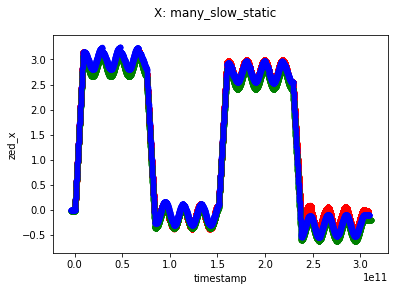

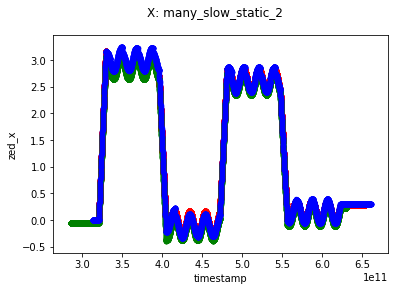

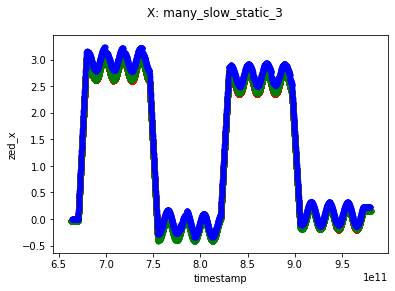

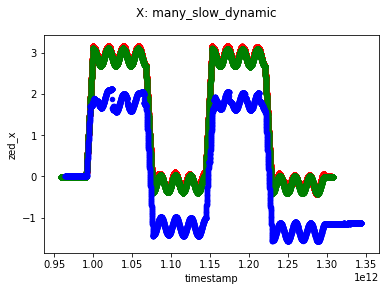

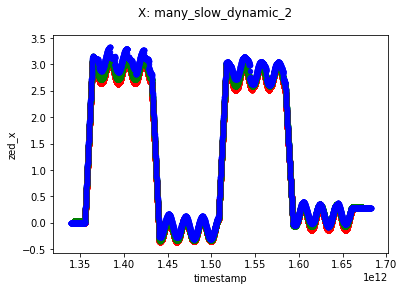

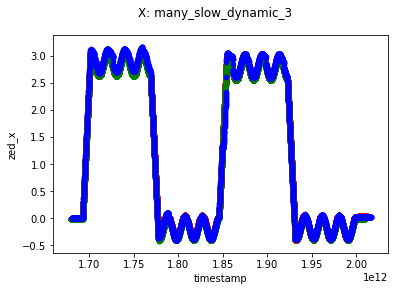

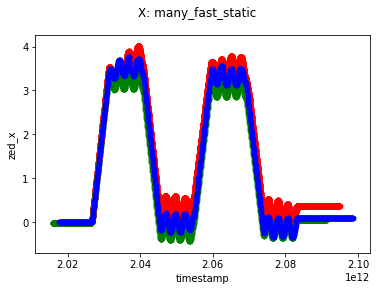

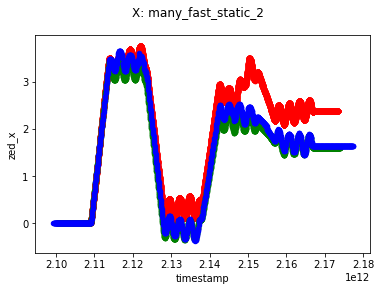

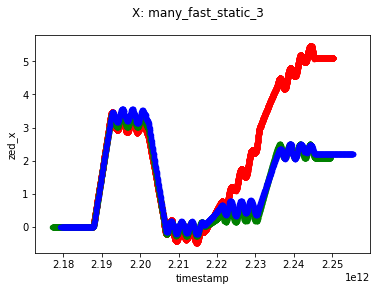

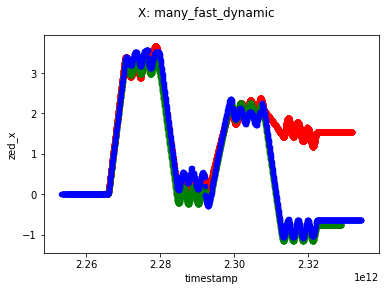

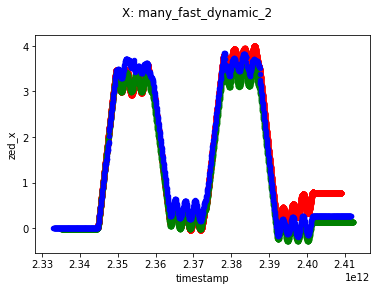

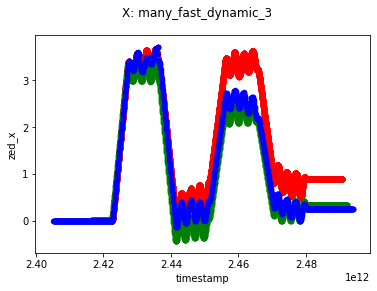

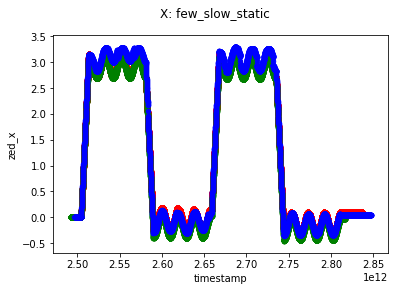

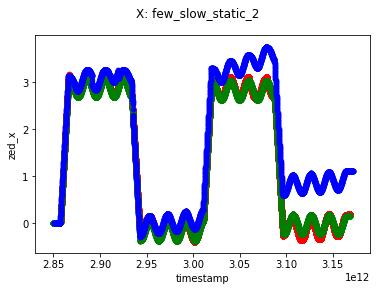

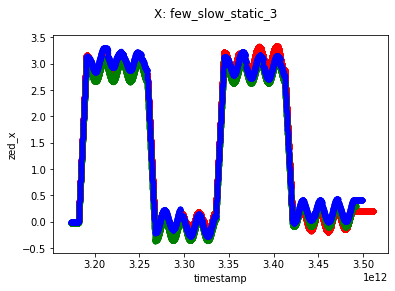

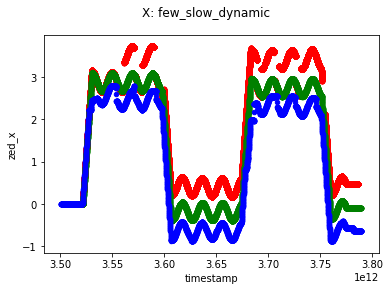

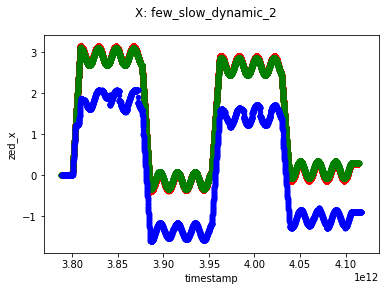

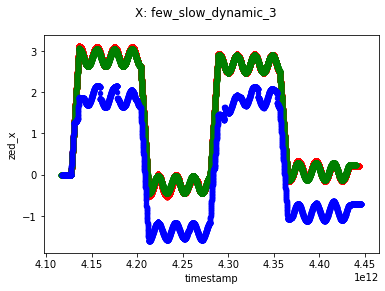

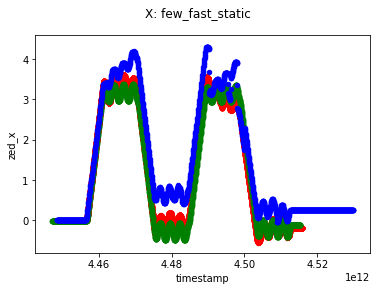

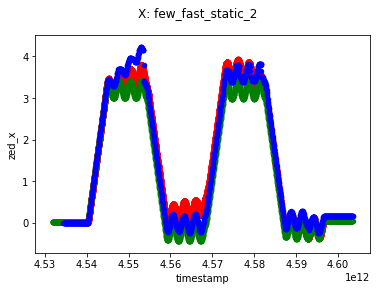

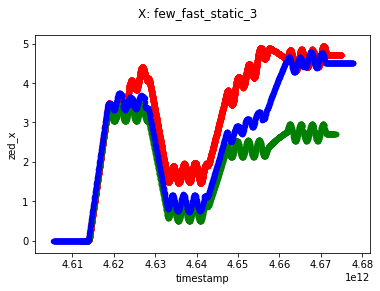

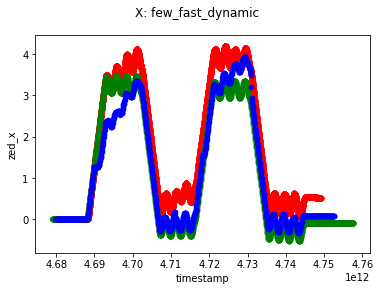

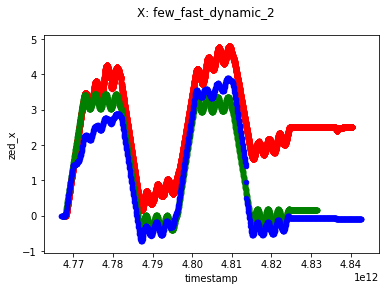

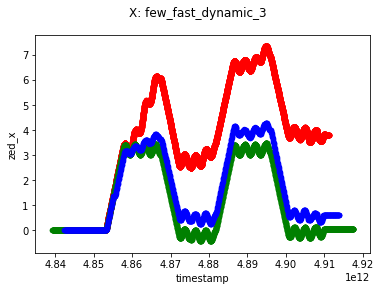

In [18]:
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='realsense_x', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='opti_x', color='g', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='zed_x', color='b', ax=plot)
    plt.suptitle('X: ' + run)

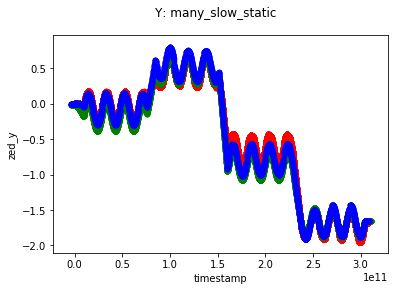

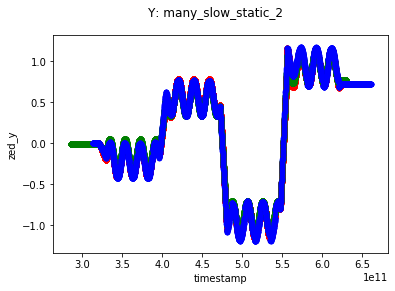

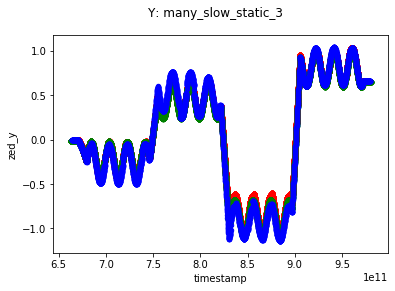

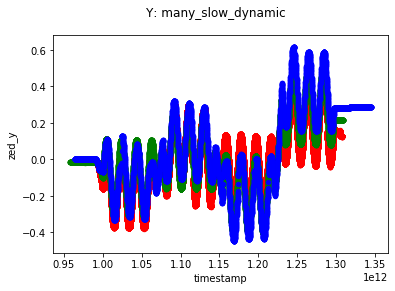

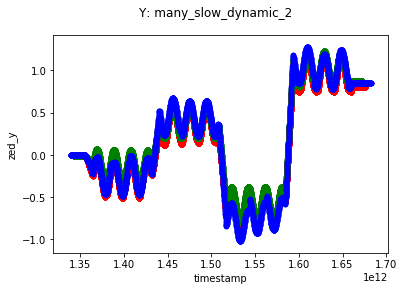

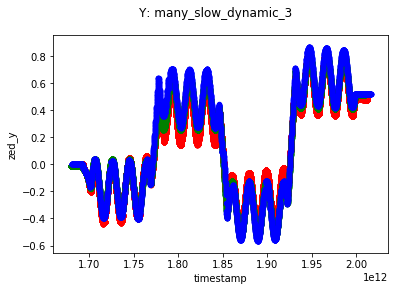

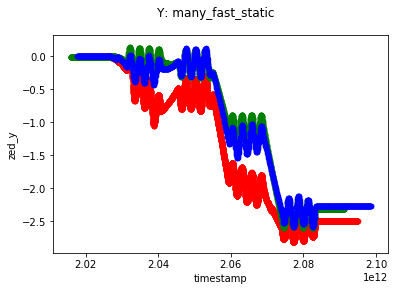

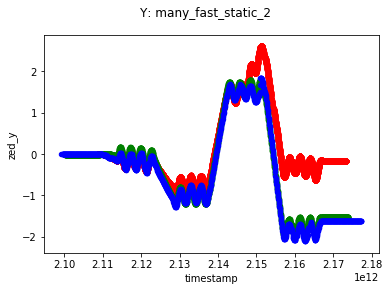

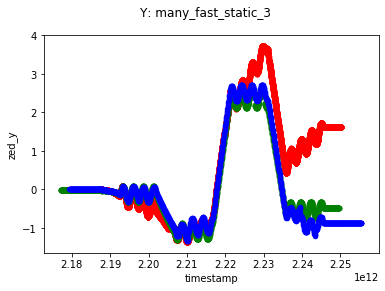

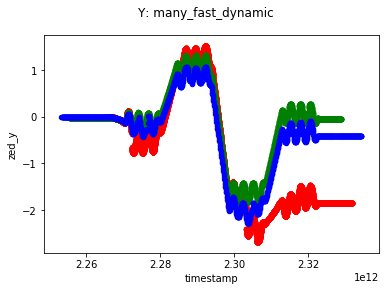

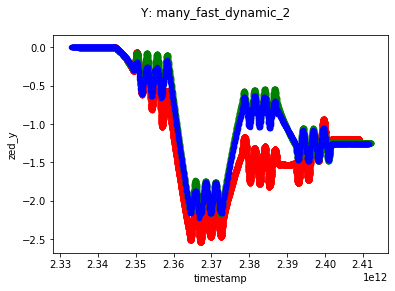

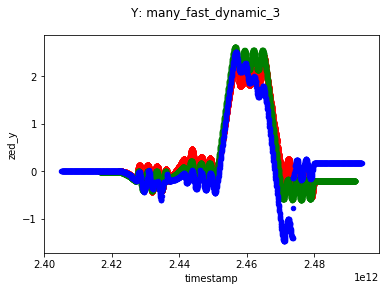

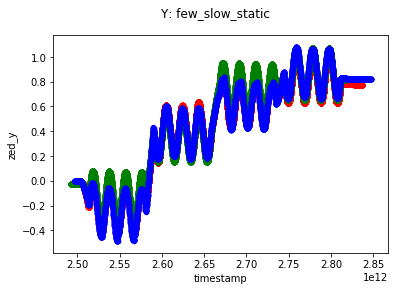

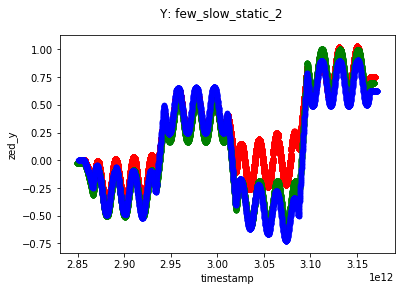

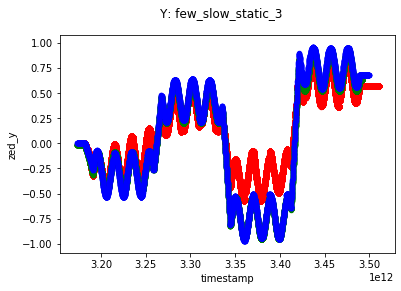

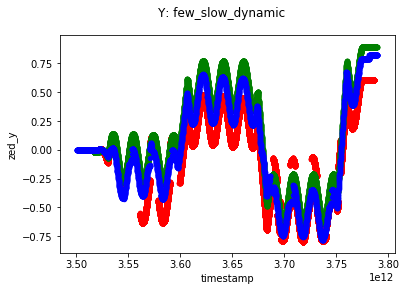

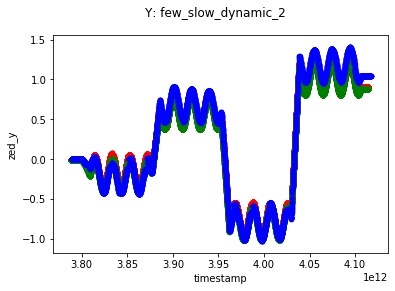

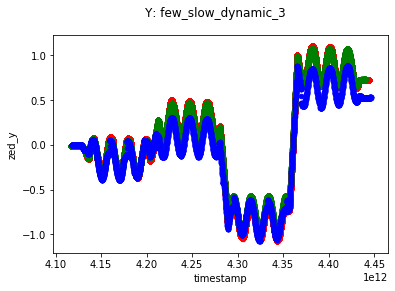

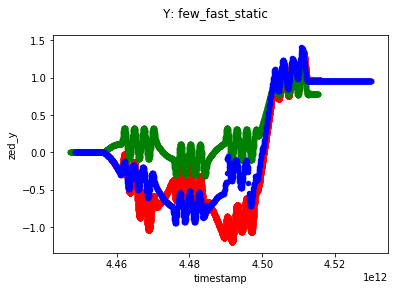

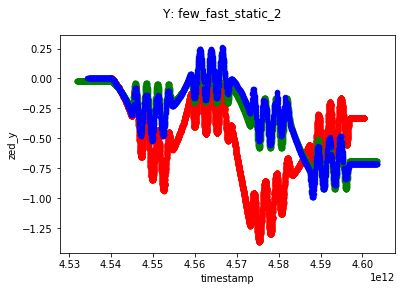

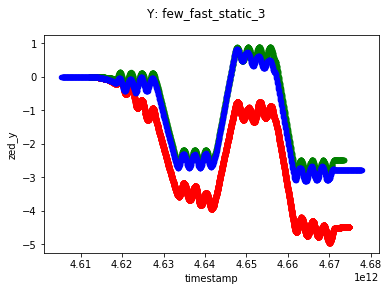

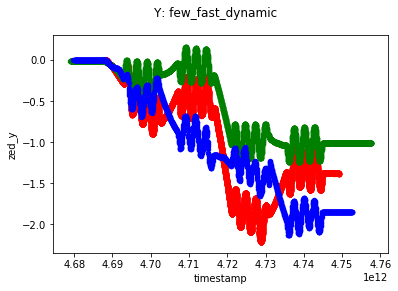

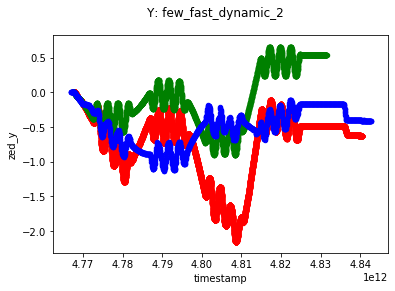

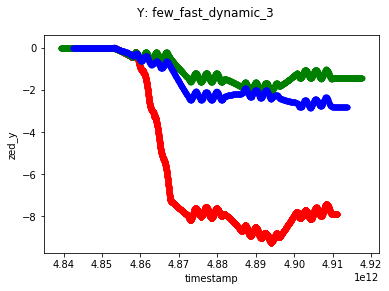

In [19]:
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='realsense_y', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='opti_y', color='g', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='zed_y', color='b', ax=plot)
    plt.suptitle('Y: ' + run)

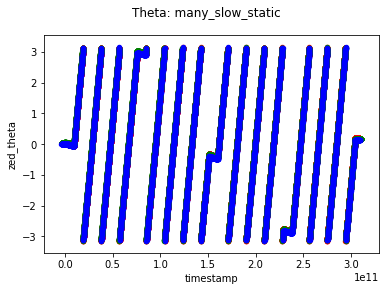

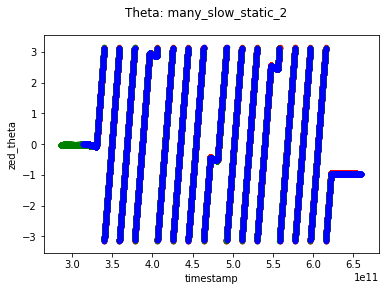

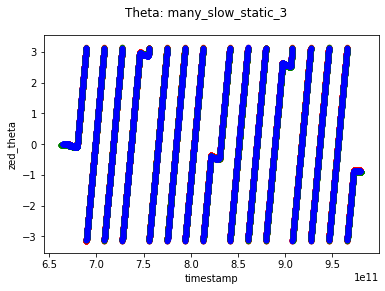

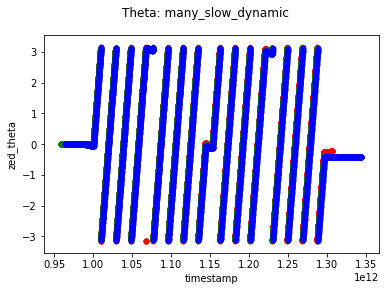

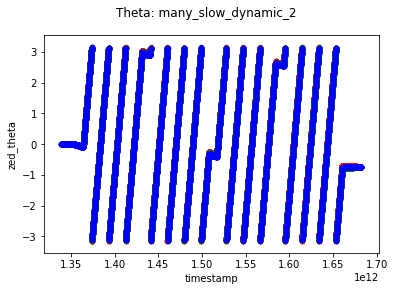

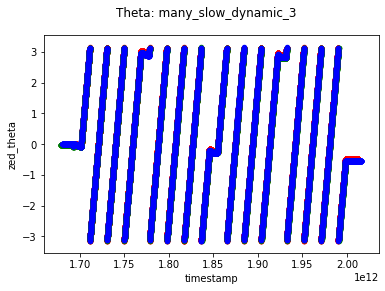

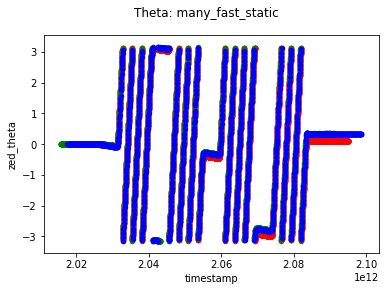

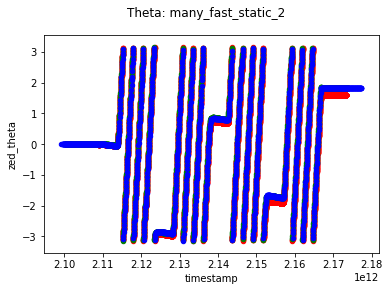

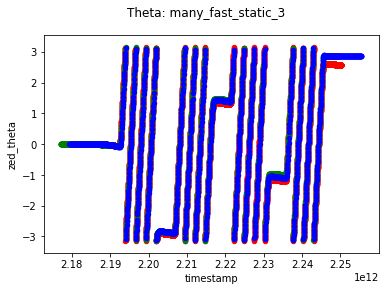

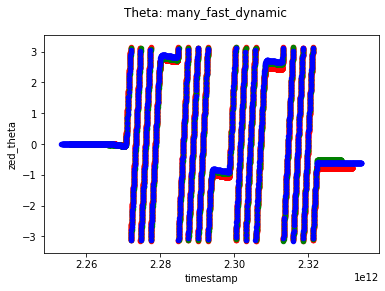

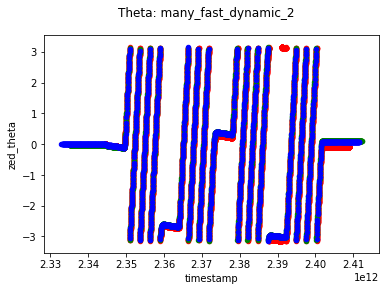

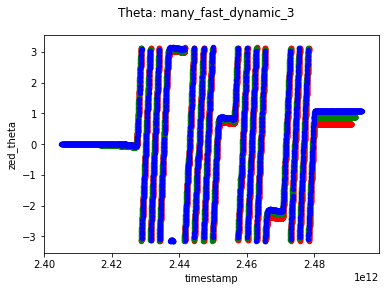

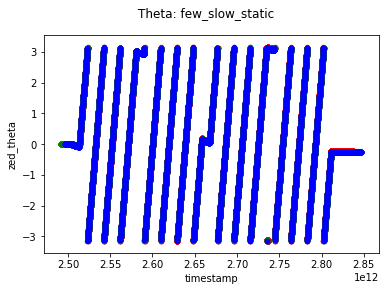

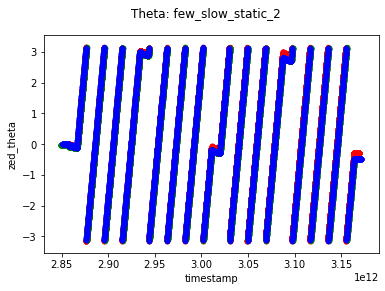

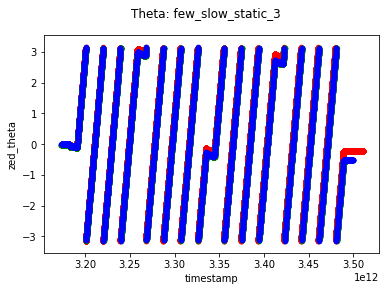

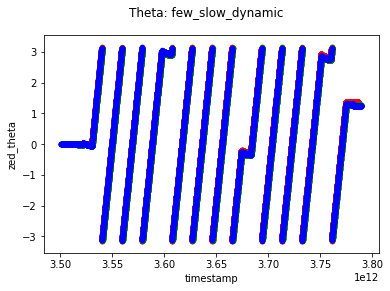

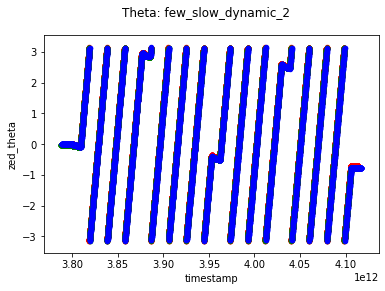

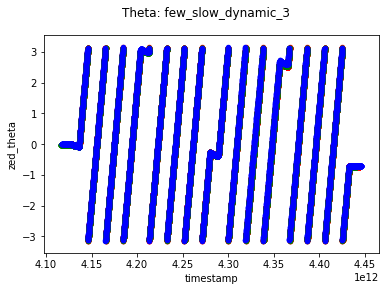

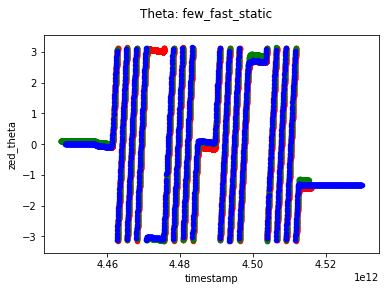

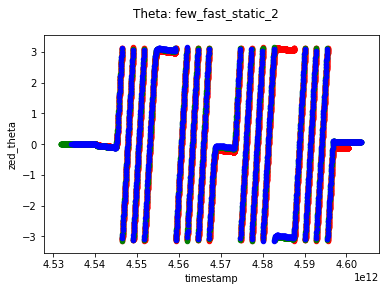

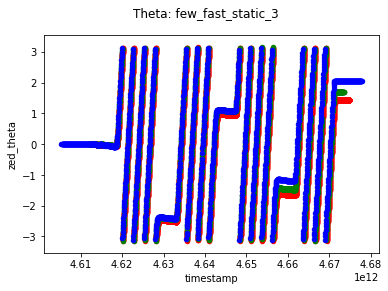

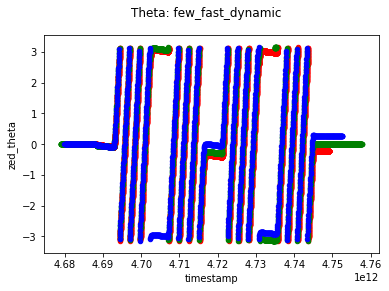

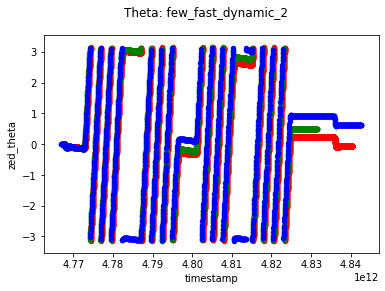

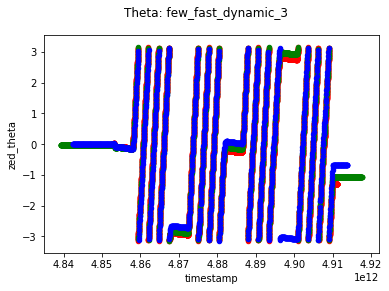

In [20]:
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='realsense_theta', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='opti_theta', color='g', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='zed_theta', color='b', ax=plot)
    plt.suptitle('Theta: ' + run)

## Fill NaN values

In [21]:
for run in runs:
    bench_data = merged_data[run][['timestamp','vel_linear']]
    bench_data = bench_data.dropna(how='any')
    merged_data[run] = merged_data[run][merged_data[run]['timestamp']<= bench_data['timestamp'].max()]

In [22]:
fill_keys = ['timestamp', 'vel_linear', 'vel_angular', 'opti_x', 'opti_y',
            'opti_theta']

In [23]:
for run in runs:
    merged_data[run][fill_keys] = merged_data[run][fill_keys].fillna(method='ffill')
    merged_data[run][fill_keys] = merged_data[run][fill_keys].fillna(method='bfill')

In [24]:
'''
# XY plot
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_x', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='odom_x', color='g', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='realsense_x', color='b', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='zed_x', color='c', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='orb_x', color='m', ax=plot)
    plt.suptitle('X: '+ run)
    
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_y', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='odom_y', color='g', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='realsense_y', color='b', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='zed_y', color='c', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='orb_y', color='m', ax=plot)
    plt.suptitle('Y: '+ run)
'''

"\n# XY plot\nfor run in runs:\n    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_x', color='r')\n    merged_data[run].plot.scatter(x='timestamp', y='odom_x', color='g', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='realsense_x', color='b', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='zed_x', color='c', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='orb_x', color='m', ax=plot)\n    plt.suptitle('X: '+ run)\n    \n    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_y', color='r')\n    merged_data[run].plot.scatter(x='timestamp', y='odom_y', color='g', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='realsense_y', color='b', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='zed_y', color='c', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='orb_y', color='m', ax=plot)\n    plt.suptitle('Y: '+ run)\n"

In [25]:
'''
# theta plot
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_theta', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='odom_theta', color='g', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='realsense_theta', color='b', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='zed_theta', color='c', ax=plot)
    merged_data[run].plot.scatter(x='timestamp', y='orb_theta', color='m', ax=plot)
    plt.suptitle('Theta: ' + run)
'''

"\n# theta plot\nfor run in runs:\n    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_theta', color='r')\n    merged_data[run].plot.scatter(x='timestamp', y='odom_theta', color='g', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='realsense_theta', color='b', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='zed_theta', color='c', ax=plot)\n    merged_data[run].plot.scatter(x='timestamp', y='orb_theta', color='m', ax=plot)\n    plt.suptitle('Theta: ' + run)\n"

## Scale ORB-Slam data

In [26]:
def computeCost(x, y, ref_x, ref_y, s):
    m = x.dropna(how='any').shape[0]
    J = 1/2/m * (np.square(s['x']*x - ref_x) + np.square(s['y']*y - ref_y)).dropna(how='any').sum()
    return J

def gradientDescent(x, y, ref_x, ref_y, s, alpha, num_iters):
    m = x.dropna(how='any').shape[0]
    J_history = np.zeros(num_iters)
    for i in range(num_iters):
        s['x'] -= alpha/m * ((s['x']*x - ref_x).dropna(how='any')*x.dropna(how='any')).sum()
        s['y'] -= alpha/m * ((s['y']*y - ref_y).dropna(how='any')*y.dropna(how='any')).sum()
        J_history[i] = computeCost(x, y, ref_x, ref_y, s);
    return s, J_history

In [27]:
scale = {}
cost = {}
alpha = 1.5
num_iters = 1500
for run in runs:
    scale[run] = {'x':0,'y':0}
    sample_length = math.floor(merged_data[run].size/7)
    scale[run], cost[run] = gradientDescent(merged_data[run]['orb_x'].iloc[0:sample_length], merged_data[run]['orb_y'].iloc[0:sample_length],
                                            merged_data[run]['opti_x'].iloc[0:sample_length], merged_data[run]['opti_y'].iloc[0:sample_length],
                                            scale[run], alpha, num_iters)

In [28]:
'''
for run in runs:
    plt.plot(cost[run])
    plt.suptitle(run)
'''

'\nfor run in runs:\n    plt.plot(cost[run])\n    plt.suptitle(run)\n'

In [29]:
for run in runs:
    merged_data[run]['orb_x'] = scale[run]['x'] * merged_data[run]['orb_x']
    merged_data[run]['orb_y'] = scale[run]['y'] * merged_data[run]['orb_y']

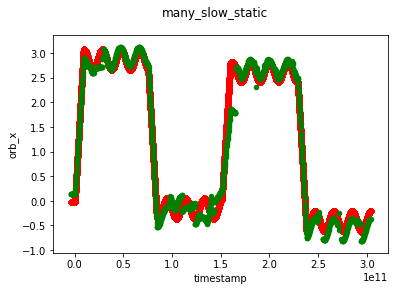

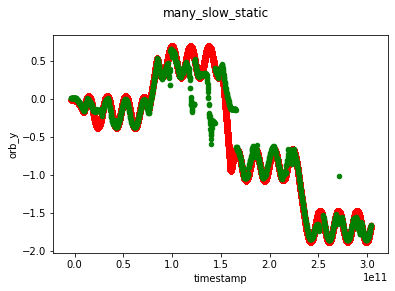

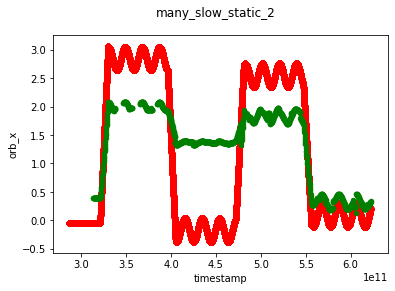

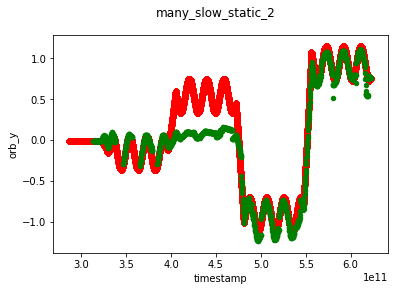

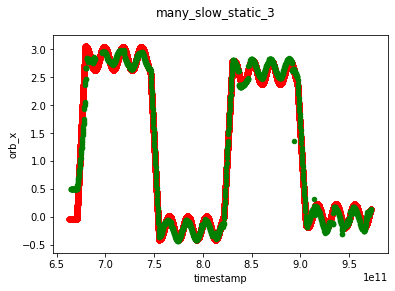

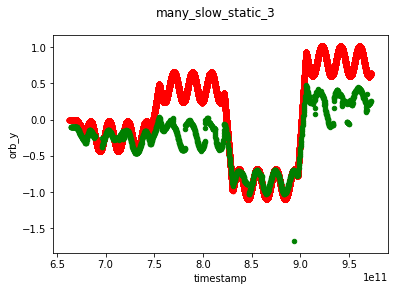

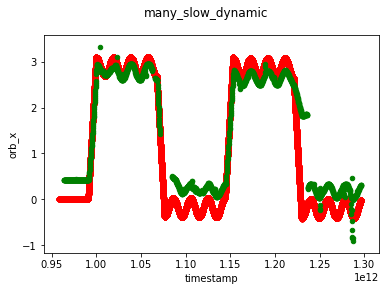

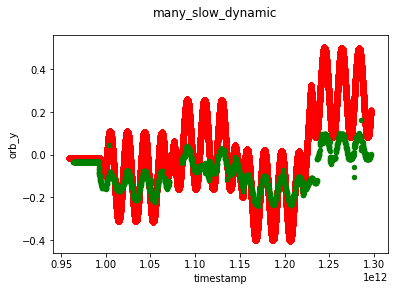

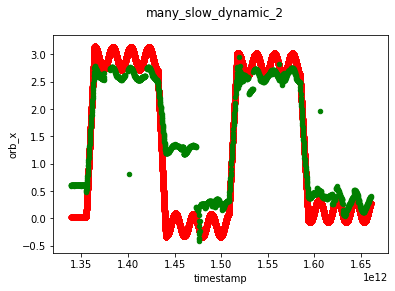

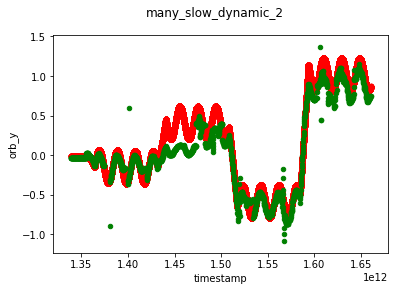

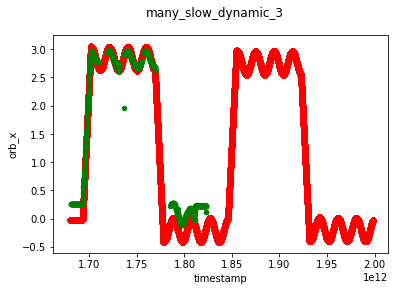

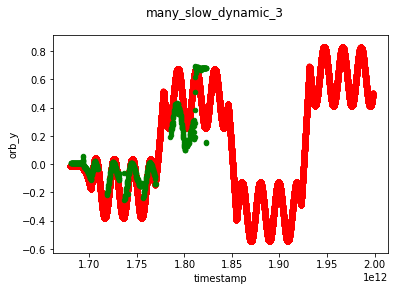

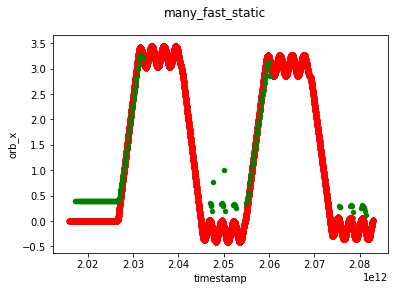

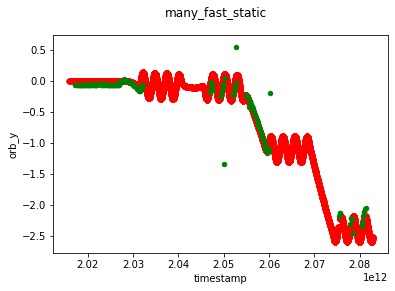

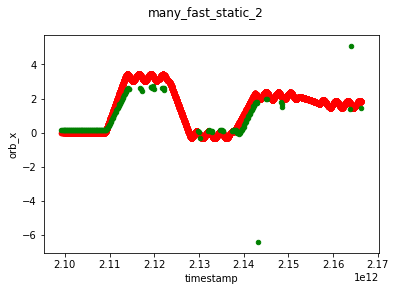

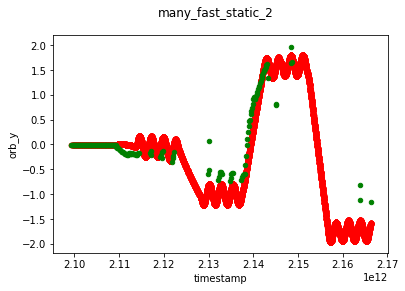

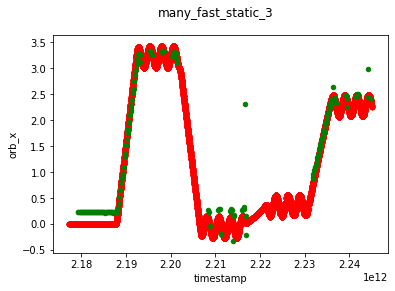

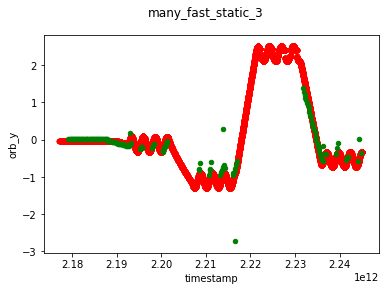

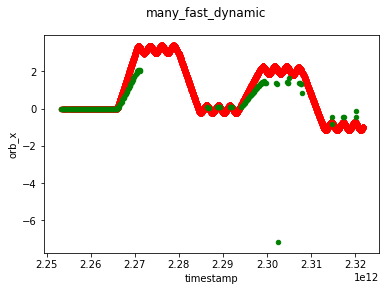

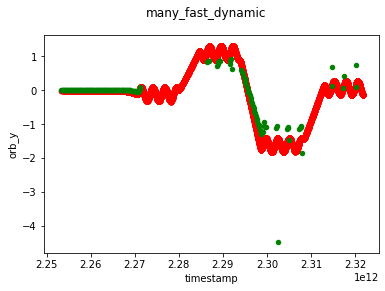

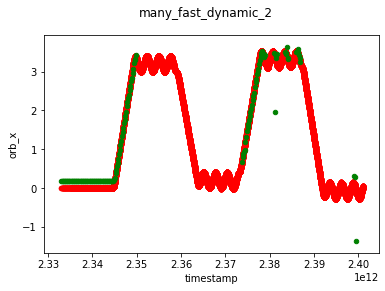

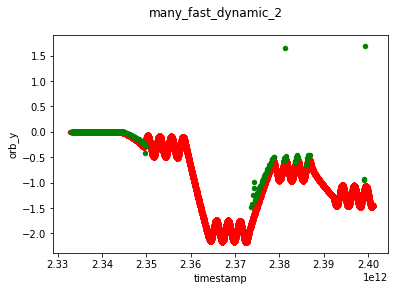

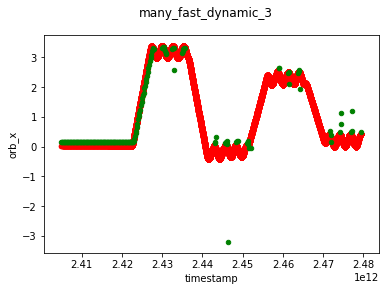

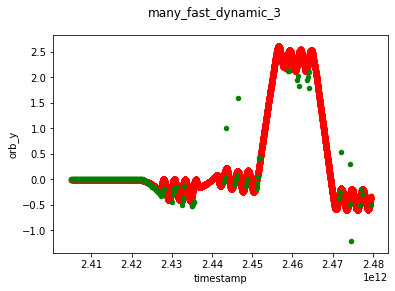

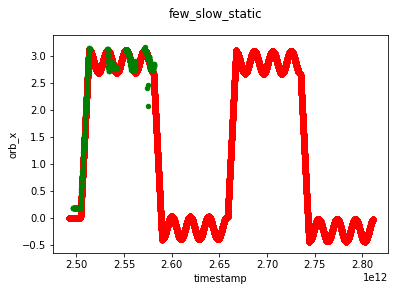

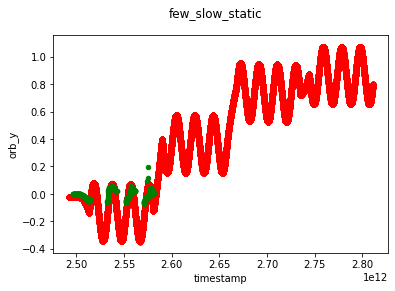

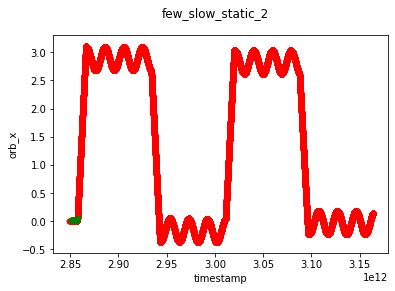

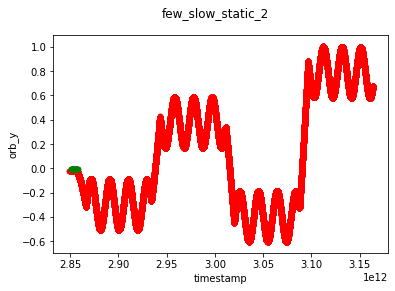

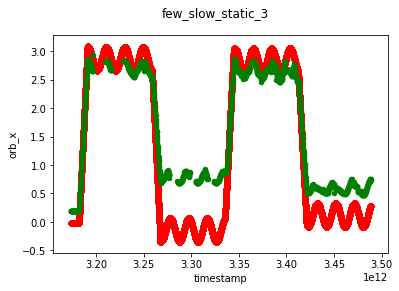

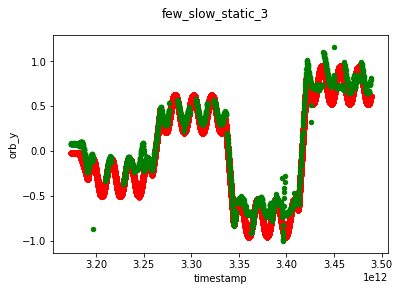

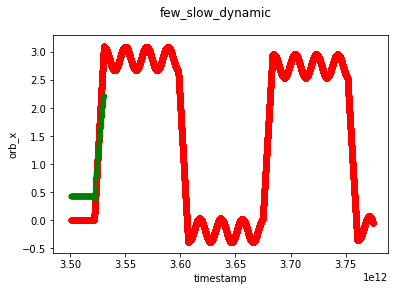

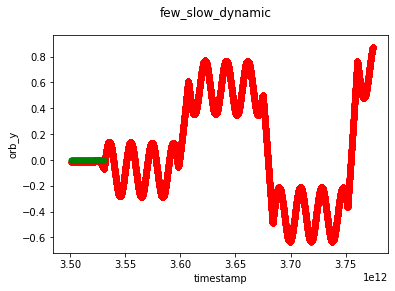

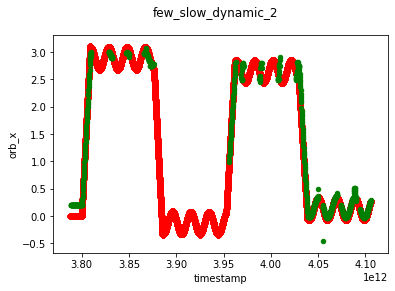

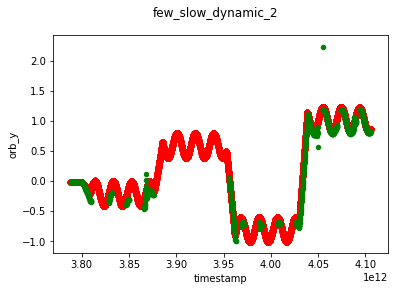

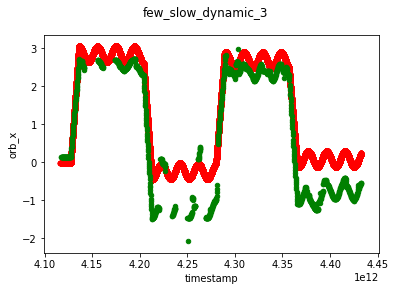

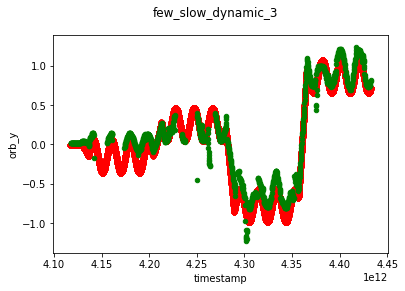

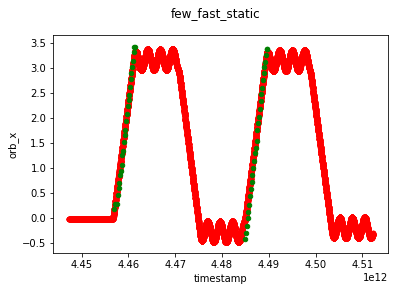

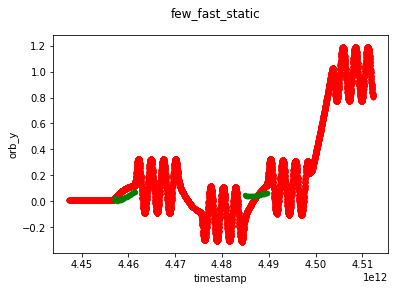

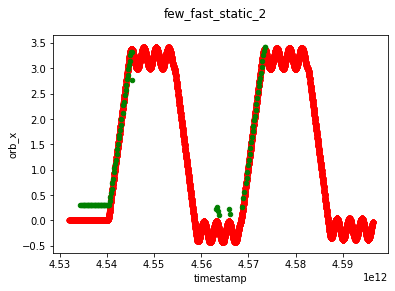

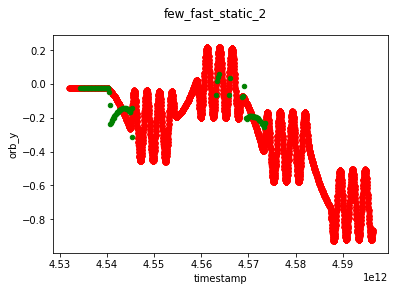

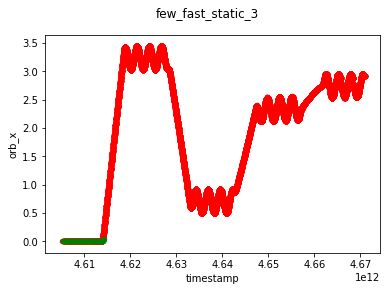

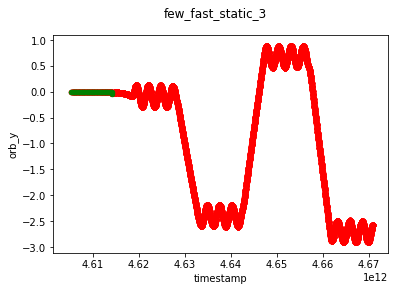

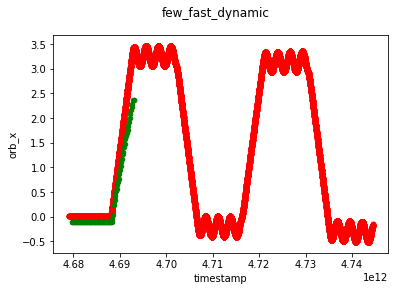

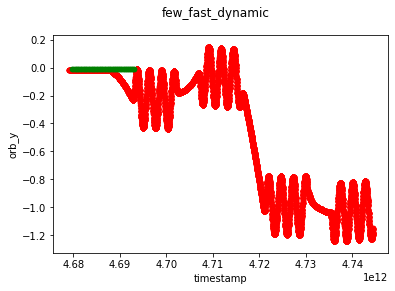

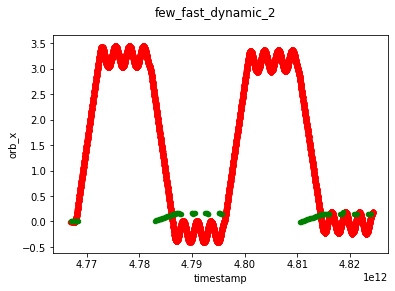

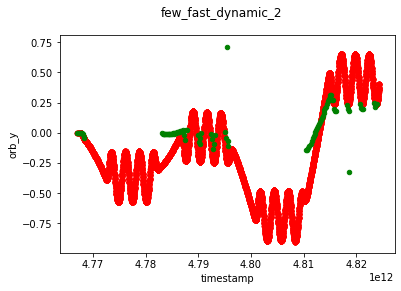

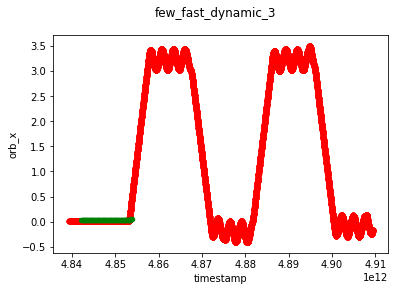

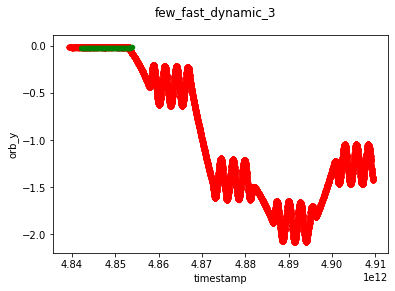

In [30]:
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_x', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='orb_x', color='g', ax=plot)
    plt.suptitle(run)
    
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_y', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='orb_y', color='g', ax=plot)
    plt.suptitle(run)

## Add transformation for camera to robot center
The camera is 18.5 cm in front of the robot center (x direction)

In [31]:
dis = 0.215

In [32]:
for run in runs:
    merged_data[run]['odom_x'] += dis * np.cos(merged_data[run]['odom_theta']) - dis
    merged_data[run]['odom_y'] += dis * np.sin(merged_data[run]['odom_theta'])

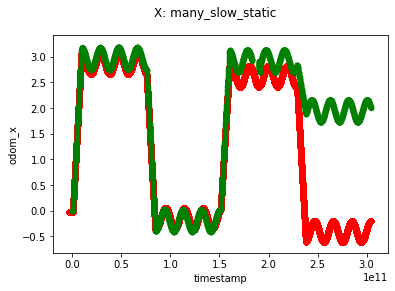

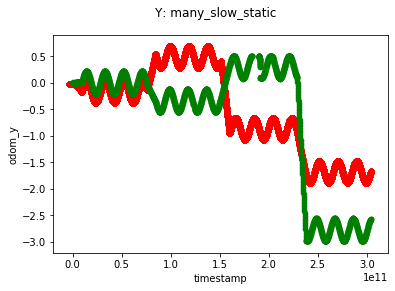

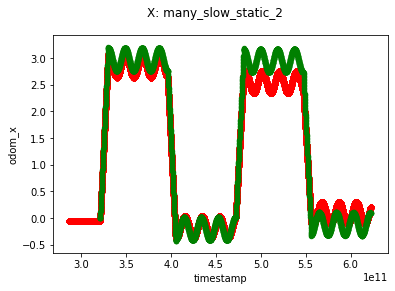

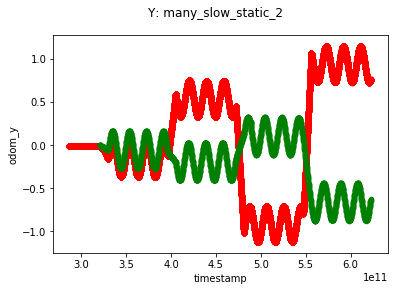

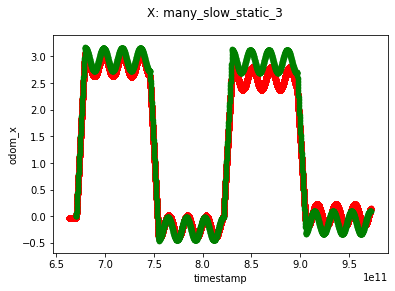

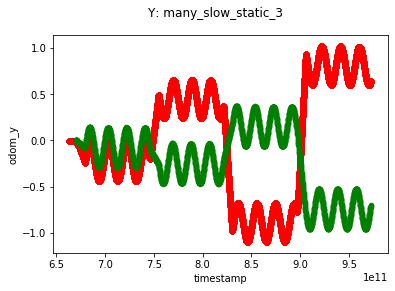

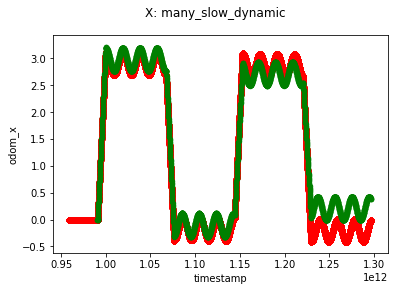

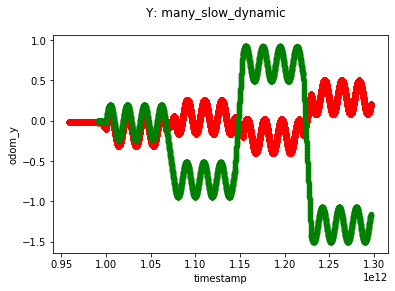

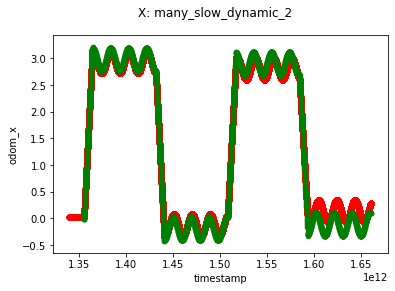

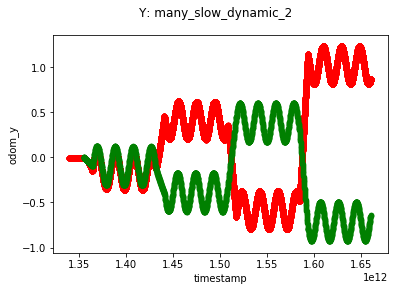

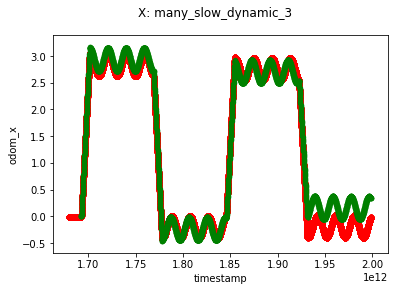

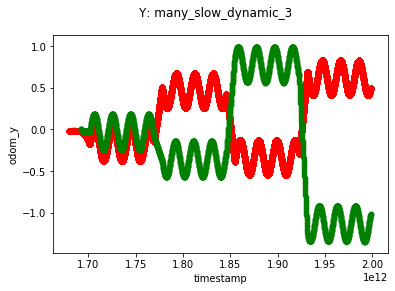

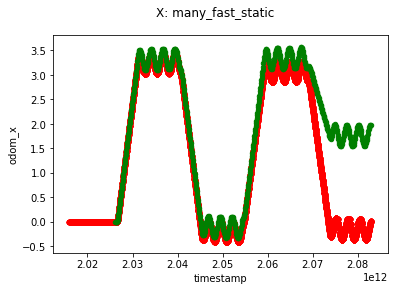

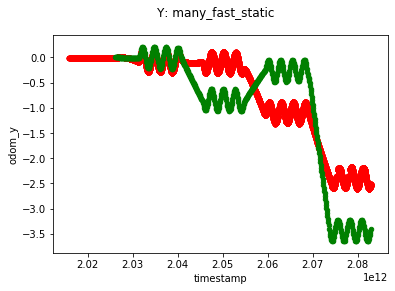

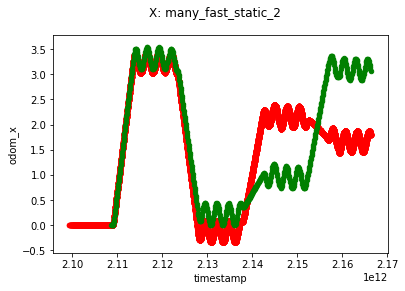

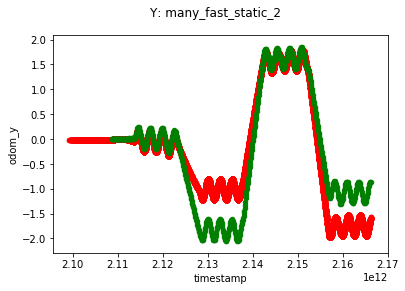

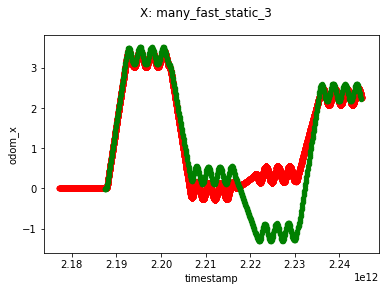

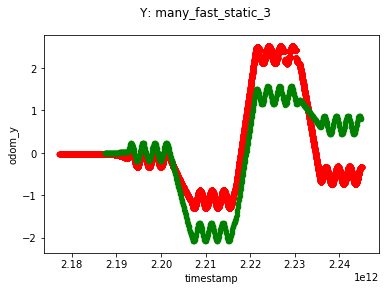

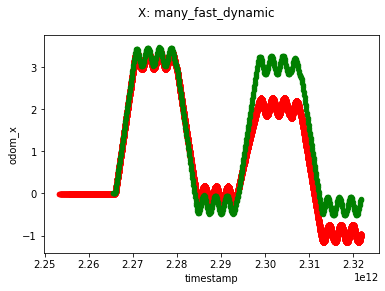

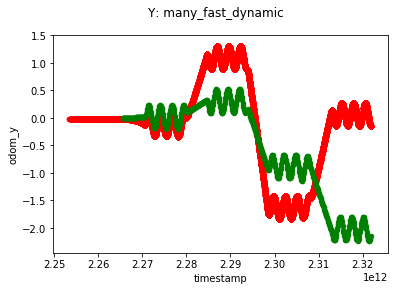

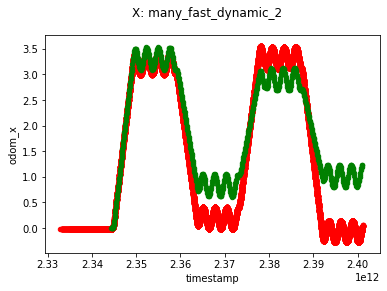

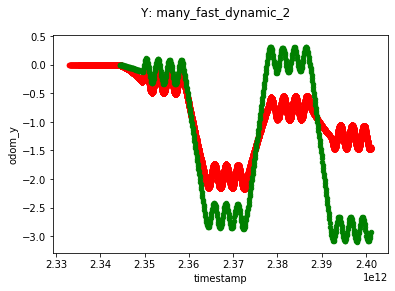

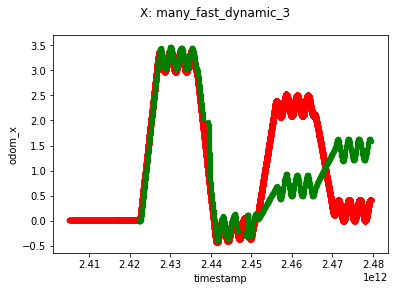

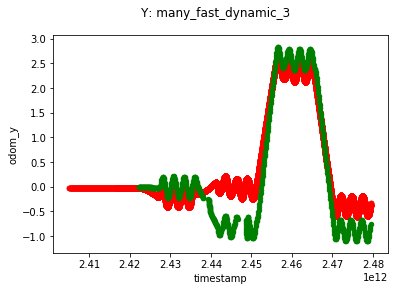

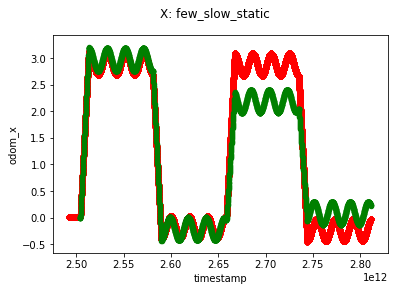

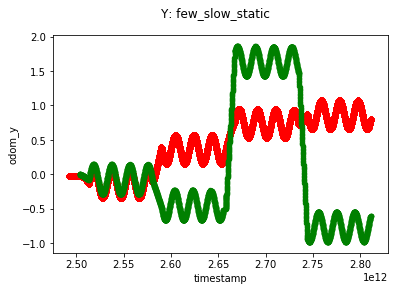

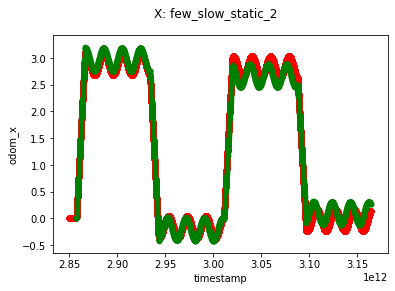

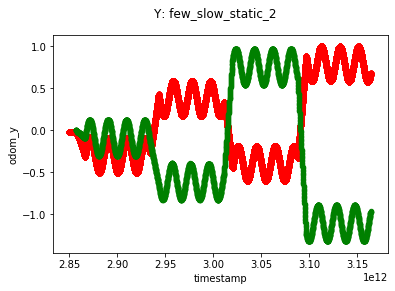

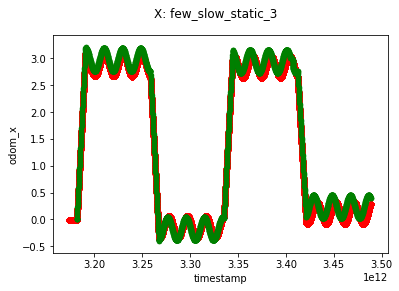

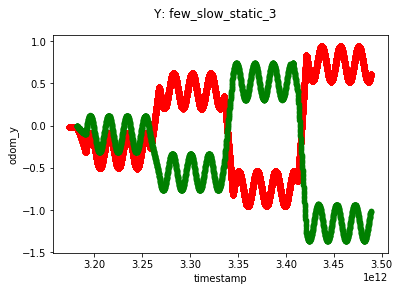

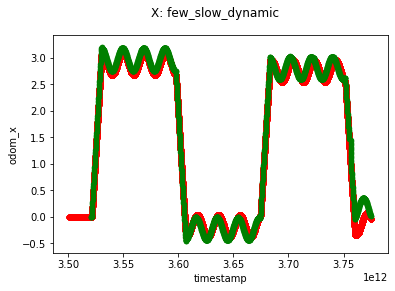

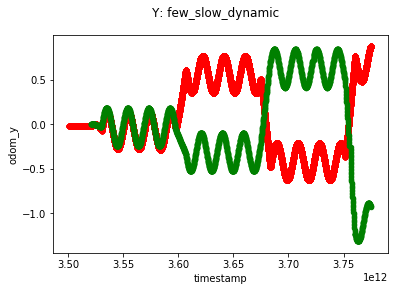

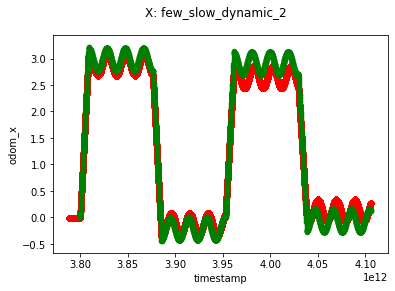

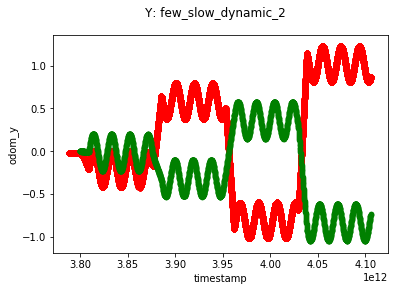

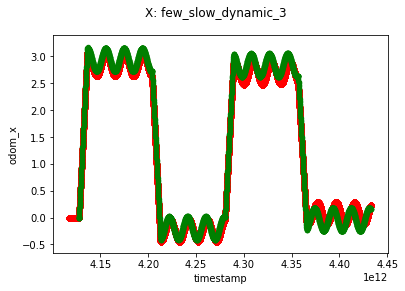

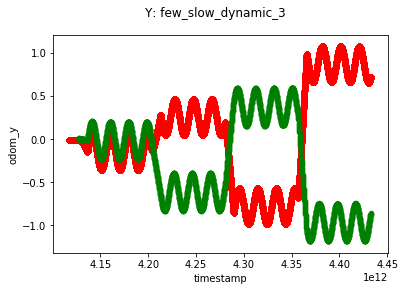

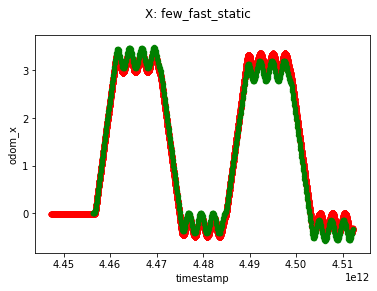

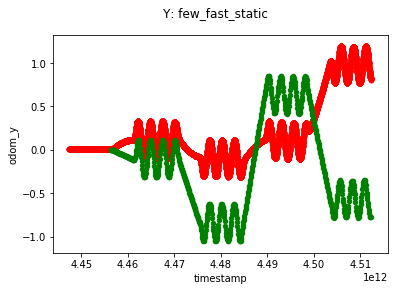

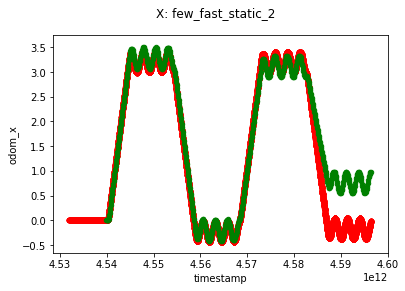

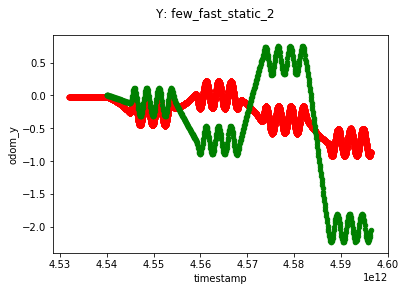

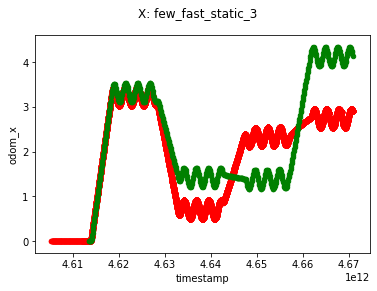

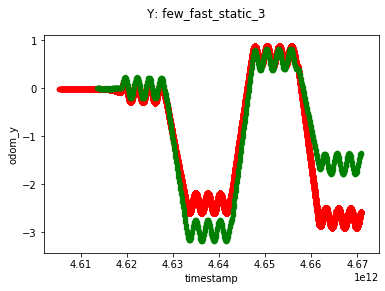

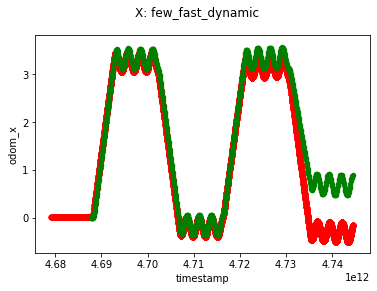

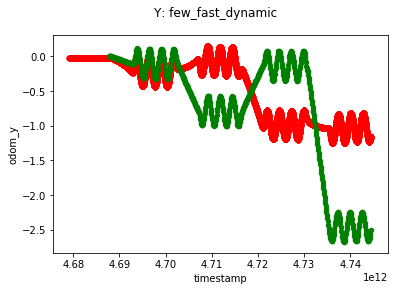

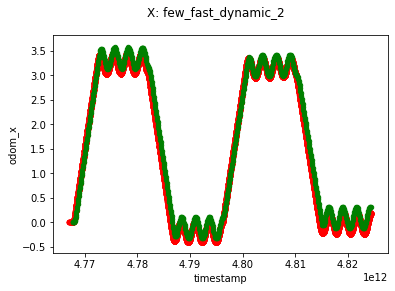

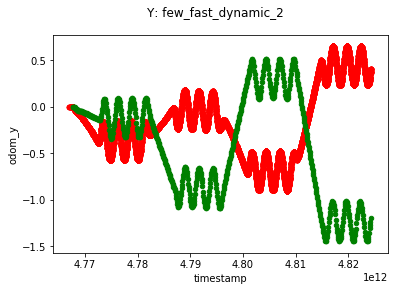

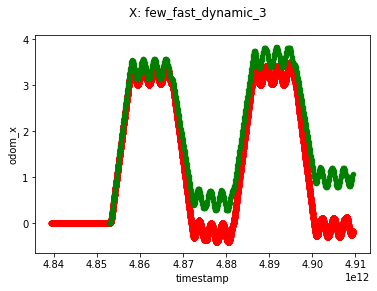

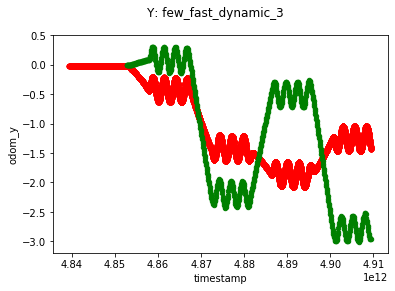

In [33]:
# XY plot
for run in runs:
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_x', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='odom_x', color='g', ax=plot)
    plt.suptitle('X: '+ run)
    
    plot =  merged_data[run].plot.scatter(x='timestamp', y='opti_y', color='r')
    merged_data[run].plot.scatter(x='timestamp', y='odom_y', color='g', ax=plot)
    plt.suptitle('Y: '+ run)

## Calculate error

In [34]:
def Trans_error(x, y, ref_x, ref_y):
    trans = np.sqrt(np.square(x - ref_x) + np.square(y - ref_y))
    return trans

def Rot_error(theta, ref_theta):
    rot = np.absolute(fit_in_pi(theta - ref_theta))
    return rot

def D_error(e):
    key = e.keys()
    err = e[key[0:-1]].dropna(how='any')
    err[key[-1]] = err[key[1]]
    err[key[-1]].iloc[0] = 0
    err[key[-1]].iloc[1:] = 10**9 * np.divide((err[key[1]].values[1:] - err[key[1]].values[:-1]),(err[key[0]].values[1:] - err[key[0]].values[:-1]))
    return err[key[-1]]

In [35]:
def Calc_error(dat):
    err_data = {}
    for run in runs:
        err_data[run] = pd.DataFrame(columns=error_keys)
        err_data[run][['timestamp', 'vel_linear', 'vel_angular']] =  dat[run][['timestamp', 'vel_linear', 'vel_angular']]
        err_data[run]['odom_trans'] = Trans_error(dat[run]['odom_x'], dat[run]['odom_y'],
                                                   dat[run]['opti_x'], dat[run]['opti_y'])
        err_data[run]['odom_rot'] = Rot_error(dat[run]['odom_theta'], dat[run]['opti_theta'])
        err_data[run]['realsense_trans'] = Trans_error(dat[run]['realsense_x'], dat[run]['realsense_y'],
                                                   dat[run]['opti_x'], dat[run]['opti_y'])
        err_data[run]['realsense_rot'] = Rot_error(dat[run]['realsense_theta'], dat[run]['opti_theta'])
        err_data[run]['orb_trans'] = Trans_error(dat[run]['orb_x'], dat[run]['orb_y'],
                                                   dat[run]['opti_x'], dat[run]['opti_y'])
        err_data[run]['orb_rot'] = Rot_error(dat[run]['orb_theta'], dat[run]['opti_theta'])
        err_data[run]['zed_trans'] = Trans_error(dat[run]['zed_x'], dat[run]['zed_y'],
                                                   dat[run]['opti_x'], dat[run]['opti_y'])
        err_data[run]['zed_rot'] = Rot_error(dat[run]['zed_theta'], dat[run]['opti_theta'])
        # Calculate incremental error, normalized by time
        err_data[run]['odom_incre_trans'] = D_error(err_data[run][['timestamp','odom_trans', 'odom_incre_trans']])
        err_data[run]['realsense_incre_trans'] = D_error(err_data[run][['timestamp','realsense_trans', 'realsense_incre_trans']])
        err_data[run]['zed_incre_trans'] = D_error(err_data[run][['timestamp','zed_trans', 'zed_incre_trans']])
        err_data[run]['orb_incre_trans'] = D_error(err_data[run][['timestamp','orb_trans', 'orb_incre_trans']])
        err_data[run]['odom_incre_rot'] = D_error(err_data[run][['timestamp','odom_rot', 'odom_incre_rot']])
        err_data[run]['realsense_incre_rot'] = D_error(err_data[run][['timestamp','realsense_rot', 'realsense_incre_rot']])
        err_data[run]['zed_incre_rot'] = D_error(err_data[run][['timestamp','zed_rot', 'zed_incre_rot']])
        err_data[run]['orb_incre_rot'] = D_error(err_data[run][['timestamp','orb_rot', 'orb_incre_rot']])
    return err_data

In [36]:
error_keys = ['timestamp', 'vel_linear', 'vel_angular', 'odom_trans', 'odom_rot', 
              'realsense_trans', 'realsense_rot', 'orb_trans', 'orb_rot', 
              'zed_trans', 'zed_rot', 'odom_incre_trans', 'odom_incre_rot', 
              'realsense_incre_trans', 'realsense_incre_rot', 
              'zed_incre_trans', 'zed_incre_rot', 'orb_incre_trans', 'orb_incre_rot']

## Write results into csv files with Nan

In [37]:
csv_keys = ['timestamp', 'feature', 'speed', 'movement', 'phase', 'vel_linear', 'vel_angular', 'odom_x', 'odom_y',
            'odom_theta', 'realsense_x', 'realsense_y', 'realsense_theta', 'orb_x',
            'orb_y', 'orb_theta', 'zed_x', 'zed_y', 'zed_theta', 'opti_x', 'opti_y',
            'opti_theta', 'odom_trans', 'odom_rot', 'realsense_trans', 'realsense_rot', 
            'zed_trans', 'zed_rot', 'orb_trans', 'orb_rot', 
            'odom_incre_trans', 'odom_incre_rot', 'realsense_incre_trans', 'realsense_incre_rot', 
            'zed_incre_trans', 'zed_incre_rot', 'orb_incre_trans', 'orb_incre_rot']

In [38]:
csv_data = pd.DataFrame(columns=csv_keys)
error_data = Calc_error(merged_data)
for run in runs:
    str_parts = run.split('_')
    run_data = pd.DataFrame(columns = csv_keys)
    run_data[merged_data[run].keys()] = merged_data[run]
    run_data[error_data[run].keys()] = error_data[run]
    run_data['feature'] = str_parts[0]
    run_data['speed'] = str_parts[1]
    run_data['movement'] = str_parts[2]
    run_data['phase'] = 'stop'
    run_data['phase'][ run_data['vel_linear']>0] = 'forward'
    run_data['phase'][ run_data['vel_angular']>0] = 'turn'
    csv_data = pd.concat([csv_data, run_data], ignore_index=True)
csv_data = csv_data.sort_values(by=['timestamp'])

In [39]:
csv_data.to_csv(r'data.csv', index=False)

In [40]:
mat_keys = ['timestamp','vel_linear', 'vel_angular', 'odom_x', 'odom_y',
            'odom_theta', 'realsense_x', 'realsense_y', 'realsense_theta', 'orb_x',
            'orb_y', 'orb_theta', 'zed_x', 'zed_y', 'zed_theta', 'opti_x', 'opti_y',
            'opti_theta', 'odom_trans', 'odom_rot', 'realsense_trans', 'realsense_rot', 
            'zed_trans', 'zed_rot', 'orb_trans', 'orb_rot',
            'odom_incre_trans', 'odom_incre_rot', 'realsense_incre_trans', 'realsense_incre_rot', 
            'zed_incre_trans', 'zed_incre_rot', 'orb_incre_trans', 'orb_incre_rot']

In [41]:
for run in runs:
    mat_data = pd.DataFrame(columns = mat_keys)
    mat_data[merged_data[run].keys()] = merged_data[run]
    mat_data[error_data[run].keys()] = error_data[run]
    mat_data = mat_data.sort_values(by=['timestamp'])
    mat_data.to_csv(r'Octave/'+run+'.csv', index=False)

## Write results into csv files without Nan

In [42]:
for run in runs:
    merged_data[run] = merged_data[run].fillna(method='ffill')
    merged_data[run] = merged_data[run].fillna(method='bfill')

In [43]:
error_data = Calc_error(merged_data)

In [44]:
csv_data = pd.DataFrame(columns=csv_keys)
for run in runs:
    str_parts = run.split('_')
    run_data = pd.DataFrame(columns = csv_keys)
    run_data[merged_data[run].keys()] = merged_data[run]
    run_data[error_data[run].keys()] = error_data[run]
    run_data['feature'] = str_parts[0]
    run_data['speed'] = str_parts[1]
    run_data['movement'] = str_parts[2]
    run_data['phase'] = 'stop'
    run_data['phase'][ run_data['vel_linear']>0] = 'forward'
    run_data['phase'][ run_data['vel_angular']>0] = 'turn'
    csv_data = pd.concat([csv_data, run_data], ignore_index=True)
csv_data = csv_data.sort_values(by=['timestamp'])

In [45]:
csv_data.to_csv(r'data_fill.csv', index=False)

In [46]:
for run in runs:
    mat_data = pd.DataFrame(columns = mat_keys)
    mat_data[merged_data[run].keys()] = merged_data[run]
    mat_data[error_data[run].keys()] = error_data[run]
    mat_data = mat_data.sort_values(by=['timestamp'])
    mat_data.to_csv(r'Octave/'+run+'_fill.csv', index=False)